# AUSTIN, TX BUILDING PERMIT PROCESS


#### Source: https://data.austintexas.gov/Building-and-Development/Issued-Construction-Permits/3syk-w9eu

### Objectives:
1. An exploratory analysis on Austin's public bulding permit data to understand the landscape of construction in the city.
2. In any private and public construction project, the two most important questions are: "how much?" and "when?". With projects being as large as billions of dollars, small delays in the schedule can be disruptive and costly. Therefore, one important aspect to understand and manage is the building permit process. In this notebook we will build a predictive model to forecast how long it would take for a construction permit to be approved. 

**NOTE:** The second part is not necessarily useful in the real world. It may be the case that the time it takes for the permit to get approved depends on actions taken by the person/company who applied for the permit. In that case they are in control of how long it would take. It could also be the case that the Permit Center knows exactly how long it will take as soon as the application comes in. But, lacking either of those properties of the system, this model could prove useful by providing an estimate to both whoever requested the permit AND the City, which would then allow them to plan future work better informed.

#### The following code allows for the code in this notebook to be hidden with one click

In [1]:
from IPython.display import HTML

HTML('''<script>code_show=true; function code_toggle() {if (code_show){$('div.input').hide();} else {$('div.input').show();
 }code_show = !code_show} $( document ).ready(code_toggle);</script>
 The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

## 1. Load Libraries and Datasets

### 1.1 Libraries

In [57]:
# Data
import numpy as np
import os
import pandas as pd
import requests
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split

# Dates
from datetime import datetime
from datetime import timedelta

# Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import statsmodels.api as sm
from sklearn.base import BaseEstimator, RegressorMixin

# Neural Networks
from keras.models import Model
from keras import Input, layers

# Random Forests
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

# XGBoost
import xgboost as xg
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

# Visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# To show images in jupyter notebook
%matplotlib inline

C:\Users\dbejarano\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### 1.2 Datasets

The data is hosted on Austin's Open Data portal. Below is the code to extract and save the datasets to your computer. This code only needs to be ran once, which is why it's hashed-out. Once all the data is saved locally we will simply load it into this notebook.

We will only be using the first 100,000 observations for simplicity purposes. The analysis and models would be more robust if more data was utilized.

In [ ]:
# # DATA GATHERING: Using iteration of .json directly from website

# # url = 'https://data.austintexas.gov/Building-and-Development/Issued-Construction-Permits/3syk-w9eu/data'

# original_endpoint = 'https://data.austintexas.gov/resource/x9yh-78fz.json?'

# permits_df_all = pd.DataFrame()
# count = 0

# #CHANGE THIS CODE SO THAT FILE IS SAVED AS A LIST, TO ONLY BE CONVERTED UPON BEING IMPORTED
# while (count < 100000):
#     limit = '$limit=1000&'
#     offset = '$offset=' + str(count)
#     endpoint = original_endpoint + limit + offset
#     permits_new = pd.read_json(endpoint)
#     permits_df_all = pd.concat([permits_df_all, permits_new])
#     count = count + 1000

# # SAVE DATAFRAME

# permits_df_all_path = os.path.join(this_folder, 'permits_df_all')
# permits_df_all.to_pickle(permits_df_all_path)  # where to save it, usually as a .pkl

#### Load saved datasets:

In [2]:
this_dir = os.path.dirname(os.path.abspath("__file__"))
permits_path = os.path.join(this_dir, 'permits_df_all')
permits_df_all = pd.read_pickle(permits_path)

#### Make a copy so we can easily access the original if needed.

In [3]:
permits_df = permits_df_all.copy()

#### Observe the dataframe and data types.

In [6]:
display(permits_df.head(3))
display(permits_df.info())

,applicant_address1,applicant_address2,applicant_city,applicant_full_name,applicant_org,applicant_phone,applicantzip,applieddate,building_valuation,building_valuation_remodel,...,project_id,remodel_repair_sqft,status_current,statusdate,tcad_id,total_existing_bldg_sqft,total_job_valuation,total_new_add_sqft,total_valuation_remodel,work_class
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009-10-26T00:00:00.000,NaN,NaN,...,10358000,0.0,Final,2010-03-23T07:23:31.000,0426300210,NaN,NaN,NaN,NaN,Remodel
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-01-06T00:00:00.000,NaN,NaN,...,10384557,0.0,Final,2010-07-06T12:24:08.000,0216070616,NaN,NaN,NaN,NaN,Remodel
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-03-12T00:00:00.000,NaN,NaN,...,10410989,0.0,Expired,2010-09-15T01:09:00.000,0221081211,NaN,NaN,NaN,NaN,Remodel


<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 999
Data columns (total 65 columns):
applicant_address1              8136 non-null object
applicant_address2              19063 non-null object
applicant_city                  20386 non-null object
applicant_full_name             5910 non-null object
applicant_org                   19285 non-null object
applicant_phone                 20379 non-null object
applicantzip                    19736 non-null object
applieddate                     99997 non-null object
building_valuation              3030 non-null float64
building_valuation_remodel      13648 non-null float64
calendar_year_issued            100000 non-null int64
completed_date                  68210 non-null object
condominium                     94297 non-null object
contractor_address1             52881 non-null object
contractor_address2             81058 non-null object
contractor_city                 87594 non-null object
contractor_company_name      

None

## 2. Exploratory Data Analysis

### Missing Values
Since there is a large amount of missing values (which we know by looking at the number of non-null values for each feature) let's plot a heatmap to visually inspect where those values are located. Missing values appear in yellow, non-missing values are shown in purple.

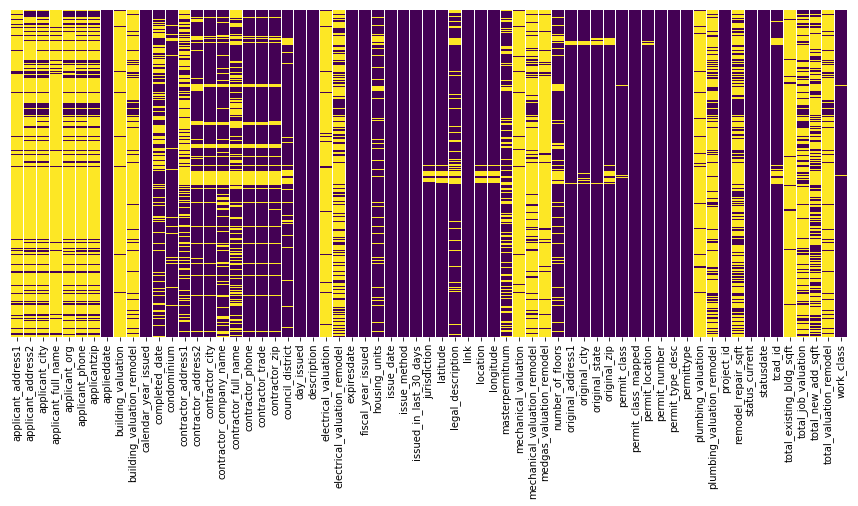

In [6]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
sns.heatmap(permits_df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
ax.set(title='Missing Values for Each Feature')

#### Analysis:
There are 21 variables which have most of their values missing (NaN). Some of them seem important for our purposes but will have to be dropped since otherwise they would leave us with a very small dataset.

At least 9 other variables have a fair number of missing values. Let's discuss the three approaches we could take:
1. Drop all rows with missing values - Unfortunately this would leave only half of our observations (~ 46K)  
2. Drop those columns which may not be as relevant to our analysis and contain many missing values
3. Fill missing values with average values

#### Feature Engineering 1 - Dropping Columns and Missing Values
The most sensible approach for this dataset is for us to first perform option #2, then see if it makes sense to do #3 for continuous variables, and then finally remove rows with any missing values.

In [7]:
#Drop features with many missing values or that may not be relevant for our analysis
feats_to_drop = ['applicant_address1', 'applicant_address2', 'applicant_city', 'applicant_full_name', 'applicant_org',
                 'applicant_phone', 'applicantzip', 'building_valuation', 'building_valuation_remodel', 
                 'electrical_valuation', 'electrical_valuation_remodel', 'mechanical_valuation',
                 'mechanical_valuation_remodel', 'plumbing_valuation', 'plumbing_valuation_remodel',
                 'remodel_repair_sqft', 'total_job_valuation', 'total_new_add_sqft', 'total_valuation_remodel', 
                 'contractor_company_name', 'masterpermitnum', 'total_existing_bldg_sqft', 'medgas_valuation_remodel',
                    'contractor_address1', 'completed_date', 'contractor_full_name','original_address1', 'permit_number',
                 'contractor_address2', 'contractor_phone', 'contractor_zip','legal_description', 'original_state', 
                 'project_id', 'statusdate', 'tcad_id', 'status_current', 'permit_type_desc',
                'permit_location', 'original_city', 'issued_in_last_30_days', 'description', 'fiscal_year_issued',
                'location', 'link']

permits_df.drop(feats_to_drop, inplace=True, axis=1)
permits_df = permits_df[permits_df['housing_units']<1000] # via visualization we notice one outlier that should be removed

# Drop all rows with missing values
print('Number of Rows with No Missing Values: ', permits_df.dropna(axis=0).shape[0])
permits_df.dropna(inplace=True, axis=0)

Number of Rows with No Missing Values:  71152


We now have 71K observations and no missing values. Now we are ready to start exploring the data.

### Dependent Variable
#### Feature Engineering 2 - Create Dependent Variable "duration"

Create a variable for the difference in days between the applieddate and issue_date. This will be our variable of interest, the dependent variable. 

After creating "duration" we can see that there is some faulty data that give us negative numbers. This is less than 30 observations so we are simply dropping them. We will also drop values with "duration" greater than 4000 days. Lastly, we will drop the applieddate and issue_date variables, since we already used them to calculate the approval time.

In addition to "duration", we will also create an "exp_duration" which is the number of days for the permit to expire since it was applied for.

In [13]:
# Convert applieddate and issue_date columns into dates
permits_df['applieddate'] = permits_df['applieddate'].apply(lambda x: datetime.strptime(x[:10], "%Y-%m-%d"))
permits_df['issue_date'] = permits_df['issue_date'].apply(lambda x: datetime.strptime(x[:10], "%Y-%m-%d"))

# Create approval_duration column 
permits_df['duration'] = permits_df['issue_date'] - permits_df['applieddate']
permits_df['duration'] = permits_df['duration'].apply(lambda x: x.days)
permits_df = permits_df[permits_df['duration'] >= 0]
permits_df = permits_df[permits_df['duration'] <  4000]

# Create exp_duration variable, similarly to above
permits_df['expiresdate'] = permits_df['expiresdate'].apply(lambda x: datetime.strptime(x[:10], "%Y-%m-%d"))
permits_df['exp_duration'] = permits_df['expiresdate'] - permits_df['applieddate']
permits_df['exp_duration'] = permits_df['exp_duration'].apply(lambda x: x.days)

# Drop permit applied, issue and expiration dates
permits_df.drop(['applieddate', 'issue_date', 'expiresdate'], inplace=True, axis=1)

### Split into Train and Test Sets

So we don't learn any information from the test set that may guide us to fit a model specific to the it, we will separate our training set into training and test sets. That way when we measure our performance on the test set we can be confident that our model will generalize to new data in a similar way.

In [14]:
train_df, test_df = train_test_split(permits_df, test_size=0.3, random_state=42)

### Scatter Plots

Let's begin by visualizing numerical variables and see if there are any visible correlations

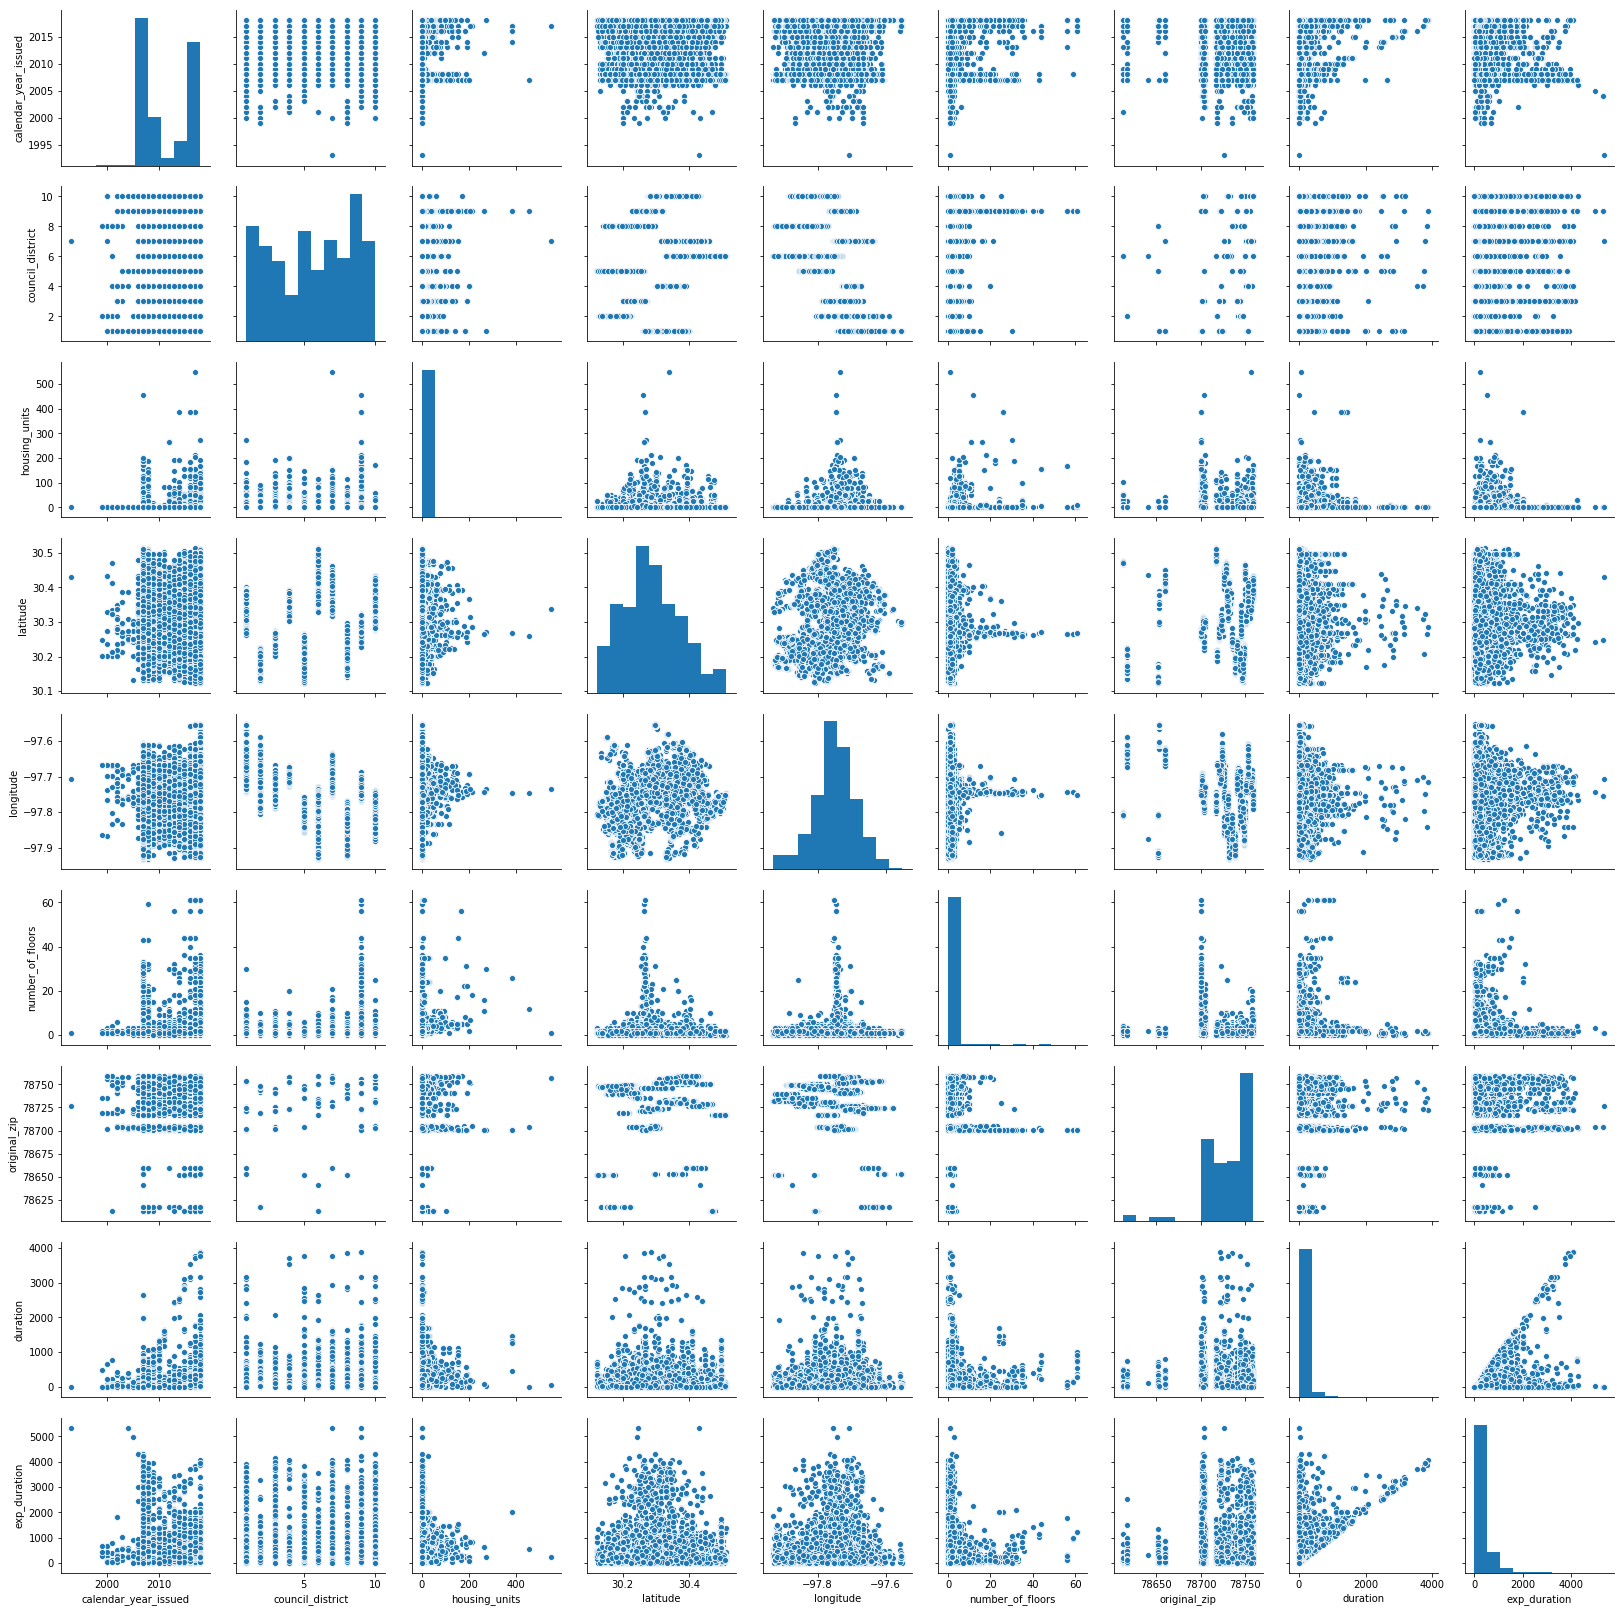

In [35]:
sns.pairplot(train_df)

#### Analysis:

There isn't much to gather from the pairplots, but a few observations are worth mentioning:
1. Duration to obtain a permit has been, in general, increasing over the years.
2. The number_of_floors seems to be negatively correlated with permit durations. This could be because there are fewer permits for taller buildings, so it's quicker to process them, or because the city prioritizes permits of larger magnitude because of the larger impact to the city.
3. The relationship between exp_duration and duration shows that the expiration date for each permit is a hard deadline, there is a clear tendency for the duration to not exceed the expiration date.

### Distribution of permit "duration" variable

[Text(0.5,0,'Log(duration)'), Text(0.5,1,'Permit Log(duration) Histogram')]

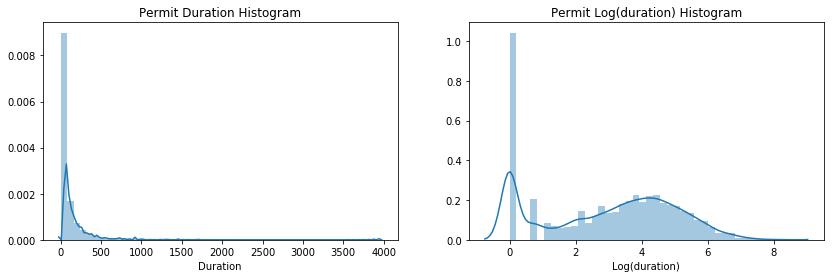

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(14, 4)
sns.distplot(train_df['duration'], ax=axes[0])
axes[0].set(xlabel='Duration', title='Permit Duration Histogram')
sns.distplot(np.log(train_df['duration']+1), ax=axes[1])
axes[1].set(xlabel='Log(duration)', title='Permit Log(duration) Histogram')

#### Analysis:
Except for the large amount of permits who were issued on the same day they were applied for, the log(duration) distribution seems to approximate a Gaussian distribution quite nicely. We will fit a model to both distributions, but it is likely that fitting to log(duration) will provide better results.

### Box Plots and Outliers

#### Feature Engineering 3 - Remove Outliers

In [17]:
# Remove Outliers
count_mean = np.mean(train_df['duration'])
count_std = np.std(train_df['duration'])
three_std = count_mean + 3*count_std

train_df = train_df[train_df['duration'] < three_std]

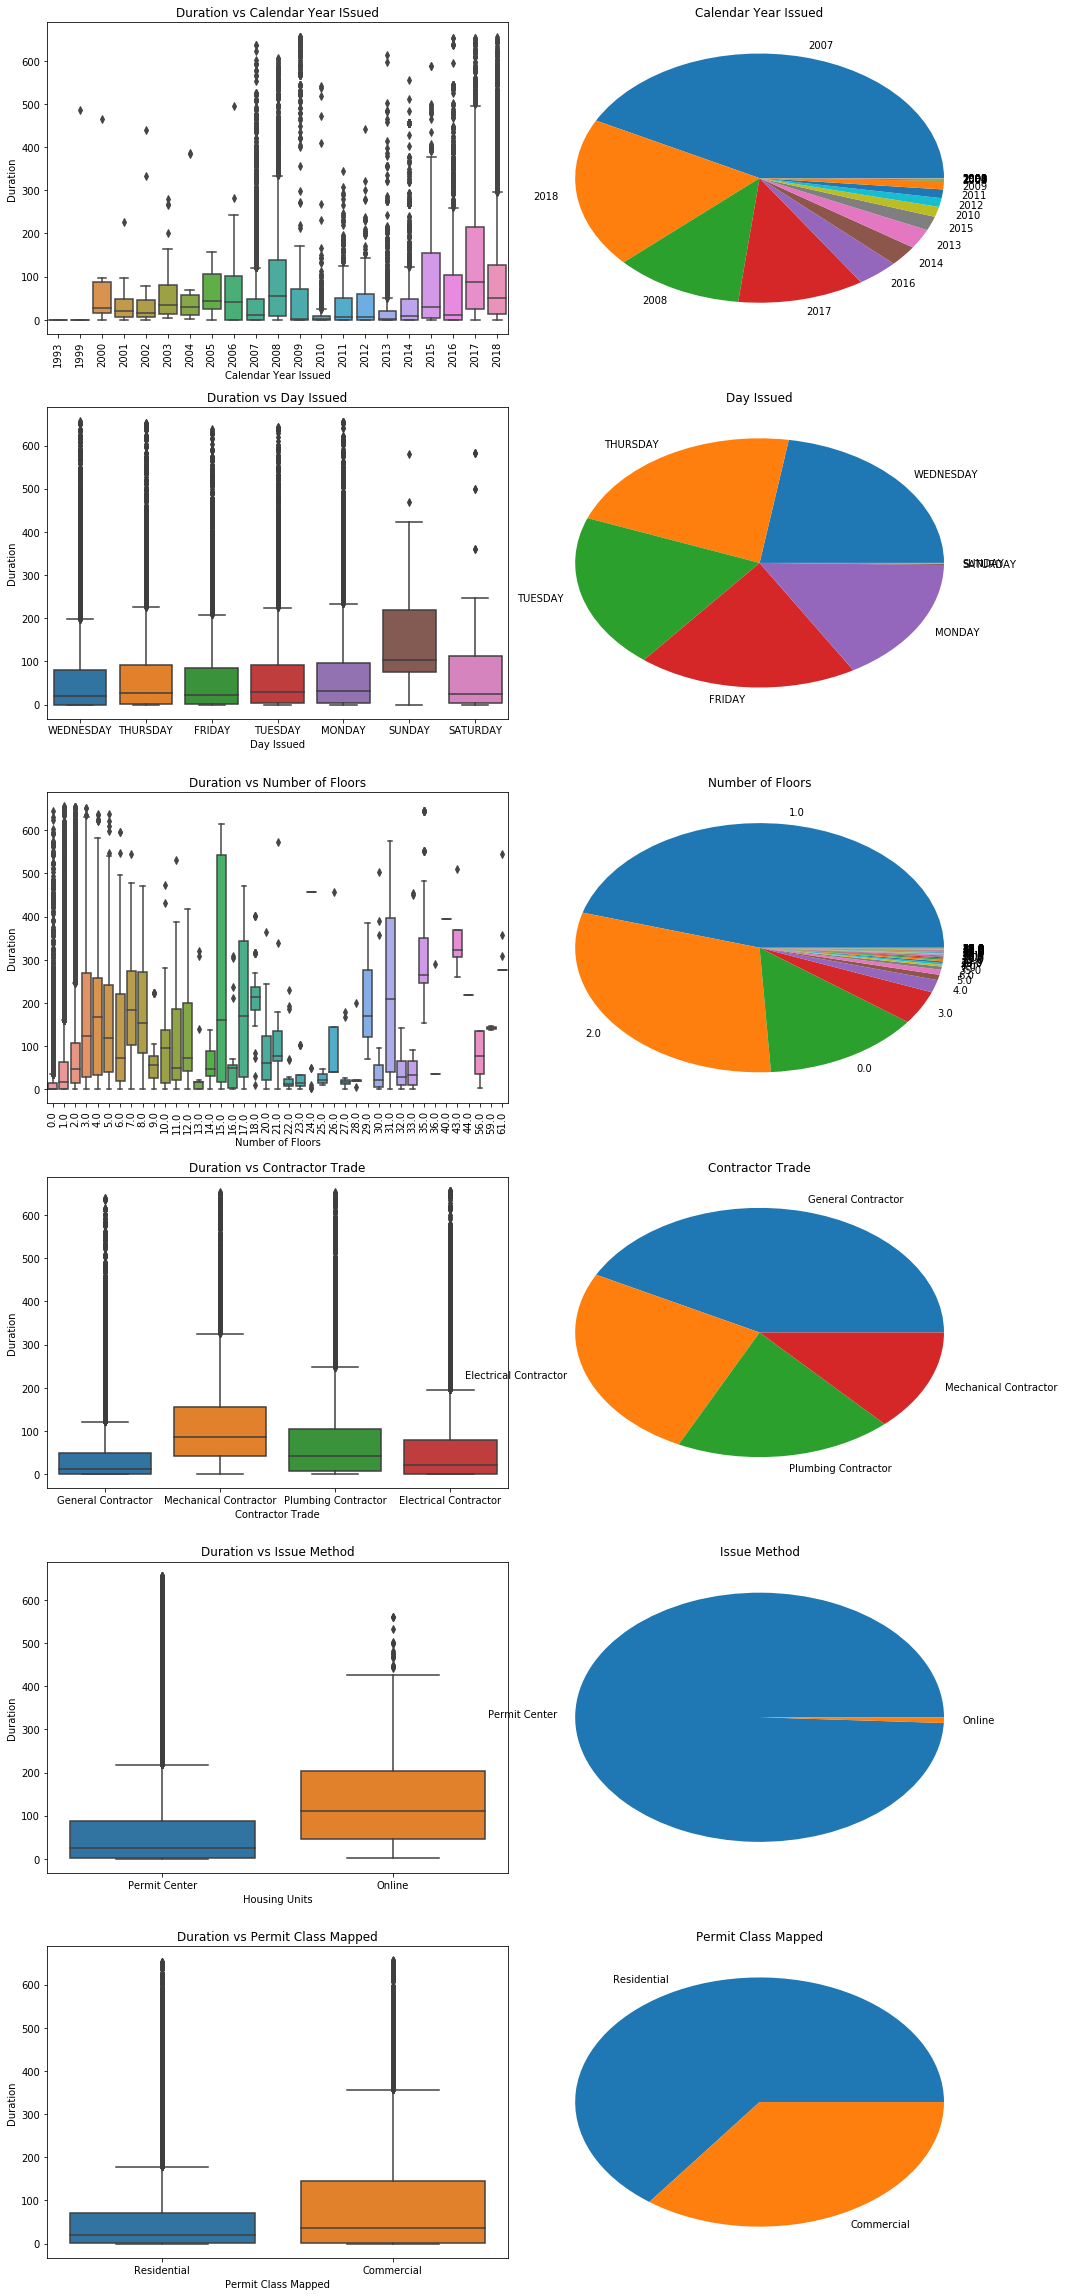

In [68]:
fig, axes = plt.subplots(nrows=6,ncols=2)
fig.set_size_inches(14, 32)

# As a function of year
sns.boxplot('calendar_year_issued', 'duration', data=train_df, ax=axes[0][0])
axes[0][0].set(ylabel='Duration', xlabel='Calendar Year Issued', title='Duration vs Calendar Year ISsued')
for item in axes[0][0].get_xticklabels():
    item.set_rotation(90)
axes[0][1].pie(train_df['calendar_year_issued'].value_counts(), labels=train_df['calendar_year_issued'].value_counts().index)
axes[0][1].set(title='Calendar Year Issued')

# As a function of day_issued
sns.boxplot('day_issued', 'duration', data=train_df, ax=axes[1][0])
axes[1][0].set(ylabel='Duration', xlabel='Day Issued', title='Duration vs Day Issued')
axes[1][1].pie(train_df['day_issued'].value_counts(), labels=train_df['day_issued'].value_counts().index)
axes[1][1].set(title='Day Issued')

# As a function of the number of floors
sns.boxplot(x='number_of_floors', y='duration', data=train_df, ax=axes[2][0])
axes[2][0].set(ylabel='Duration', xlabel='Number of Floors', title='Duration vs Number of Floors')
for item in axes[2][0].get_xticklabels():
    item.set_rotation(90)
axes[2][1].pie(train_df['number_of_floors'].value_counts(), labels=train_df['number_of_floors'].value_counts().index)
axes[2][1].set(title='Number of Floors')

# As a function of trade
sns.boxplot('contractor_trade', 'duration', data=train_df, ax=axes[3][0])
axes[3][0].set(ylabel='Duration', xlabel='Contractor Trade', title='Duration vs Contractor Trade')
axes[3][1].pie(train_df['contractor_trade'].value_counts(), labels=train_df['contractor_trade'].value_counts().index)
axes[3][1].set(title='Contractor Trade')

# As a function of jurisdiction
sns.boxplot(x='issue_method', y='duration', data=train_df, ax=axes[4][0])
axes[4][0].set(ylabel='Duration', xlabel='Housing Units', title='Duration vs Issue Method')
axes[4][1].pie(train_df['issue_method'].value_counts(), labels=train_df['issue_method'].value_counts().index)
axes[4][1].set(title='Issue Method')

# As a function of permit class
sns.boxplot('permit_class_mapped', 'duration', data=train_df, ax=axes[5][0])
axes[5][0].set(ylabel='Duration', xlabel='Permit Class Mapped', title='Duration vs Permit Class Mapped')
axes[5][1].pie(train_df['permit_class_mapped'].value_counts(), labels=train_df['permit_class_mapped'].value_counts().index)
axes[5][1].set(title='Permit Class Mapped')

plt.tight_layout() # to leave some space between graphs

#### Analysis:
The box plots of the original training data show a large amount of observations lying outside the box plot whiskers. For the remaining of the EDA we have removed some of those outliers (those beyond 3 standard deviations from the mean). However, we will test our models both with and without these outliers.

Here are some observations from the plots:
1. There appears to be some cyclical tendency to durations based on the year they were issued.
2. It appears like permits requested on a Sunday take considerably longer than those issued on any other day. This could be because those requested on Sunday are necessarily requested online and that process takes longer. It could also be that since only 40 permits were requested on Sundays, while 10,000+ were on Tuesdays and Wednesdays, there were some on Sunday that took long and greatly affected the average. It's possible, for instance, that Sunday permits were of a certain category (larger projects maybe) and took longer for that reason.
3. Beyong 5 storeys, the number_of_floors does not seem to be a good predictor of duration.
4. Permits for mechanical contracts tend to take the longest, on average.
5. Permits requested online take more than double on average compared to when requested at the Permit Center. It's worth noting however that out of the ~49K permits, only 341 were requested online.
6. Duration shows a similar distribution as a function of permit_class (commercial vs residential)

#### With this, now let's look at how the duration for permit approval has varied over time.

### Trends in Time

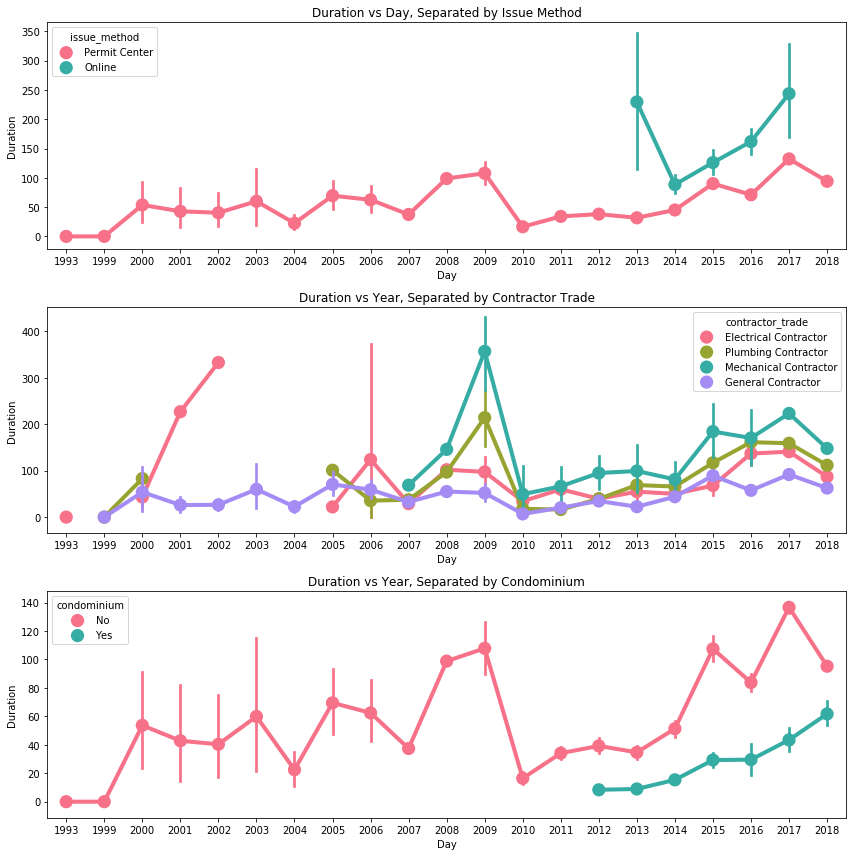

In [119]:
fig, axes = plt.subplots(nrows=3, ncols=1)
fig.set_size_inches(12, 12)

day_of_week = train_df.groupby(['issue_method', 'calendar_year_issued'], sort=True).count().reset_index()
sns.pointplot(x='calendar_year_issued', y='duration', data=train_df, hue='issue_method', ax=axes[0], join=True, scale=1.5, palette='husl')
axes[0].set(xlabel='Day', ylabel='Duration', title='Duration vs Year, Separated by Issue Method')

day_of_week = train_df.groupby(['contractor_trade', 'calendar_year_issued'], sort=True).count().reset_index()
sns.pointplot(x='calendar_year_issued', y='duration', data=train_df, ax=axes[1], hue='contractor_trade', join=True, scale=1.5, palette='husl')
axes[1].set(xlabel='Day', ylabel='Duration', title='Duration vs Year, Separated by Contractor Trade')

day_of_week = train_df.groupby(['condominium', 'calendar_year_issued'], sort=True).count().reset_index()
sns.pointplot(x='calendar_year_issued', y='duration', data=train_df,ax=axes[2], hue='condominium', join=True, scale=1.5, palette='husl')
axes[2].set(xlabel='Day', ylabel='Duration', title='Duration vs Year, Separated by Condominium')

plt.tight_layout() # to leave some space between graphs

#### Analysis:

1. Online permit requests was introduced in 2013. They do take longer on average. This correlation doesn't mean that it being online is the cause for such duration. It may be that a particular type of permit is issued online more than at the Permit Center.
2. Mechanical permits tend to take longer on average. Permits for General Contractors take the least amount of time on average.
3. Permit applications for condominiums only started in 2012, and apper to take less on average than non-condominiums.

### Map Permits
The image below maps the project location for each of the permits requested. Colors represent the duration for the permits to get approved.

For reference, the area in the middle, which has some line of separation via a horizontal line is downtown Austin (the line is the river). Right above it we see a patch of empty space, that's The University of Texas at Austin. 

,0,1,2,3,4,5,6,7,8,9
0,1.0,2.0,7.0,20.0,54.0,148.0,403.0,1096.0,2980.0,8103.0


DURATION FOR PERMIT APPROVAL (IN DAYS) PER COLOR BAR IN TABLE ABOVE


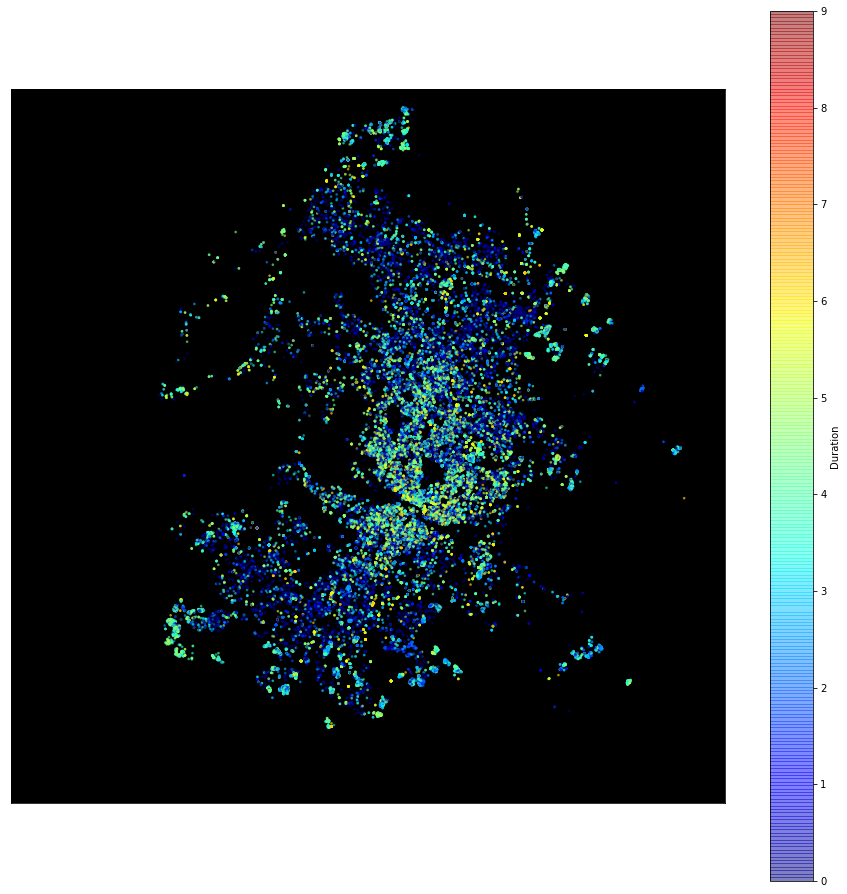

In [59]:
# Overlay plotted points on map of Austin using Basemap
# Example source: https://jakevdp.github.io/PythonDataScienceHandbook/04.13-geographic-data-with-basemap.html
# longitude is the x-axis
# Latitude is the y-axis

from mpl_toolkits.basemap import Basemap

lat = train_df['latitude'].values
lon = train_df['longitude'].values

# Draw map background
fig, axes = plt.subplots() #(5)
#plt.figure(figsize=(16,16))
fig.set_size_inches(16, 16)
axes.set_facecolor('black')
m = Basemap(projection='lcc', resolution='c', lat_0 = 30.30, lon_0 = -97.78, width = 5E4, height = 5E4)
m.scatter(lon, lat, latlon=True, c=np.log(train_df['duration']+1), s=3, cmap=plt.get_cmap('jet'), alpha=0.5)

# Create colorbar and legend
plt.colorbar(label=r'Duration')
plt.clim(0, 9)

display(pd.DataFrame([(np.exp(range(0, 10)))//1], columns=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))
print('DURATION FOR PERMIT APPROVAL (IN DAYS) PER COLOR BAR IN TABLE ABOVE')

#### Analysis:

1. We can see that most of the permits took from 0 to 100 days, approximately.
2. The duration of permit approval changes by location. Work centered around downtown tends to take longer to get approved. This could be a function of the type of work, and not so much the actual location. As we can see in the image below, the type of work also changes by location, with most of the new work occuring at the perimeter of the city, while downtown is seeing mostly repairs.

0=Remodel, 1=Change Out, 2=Repair, 3=New, 4=Demolition, 5=Addition and Remodel, 6=Addition 

MAP OF PERMITS COLORED ACCORDING TO ITS WORK CLASS


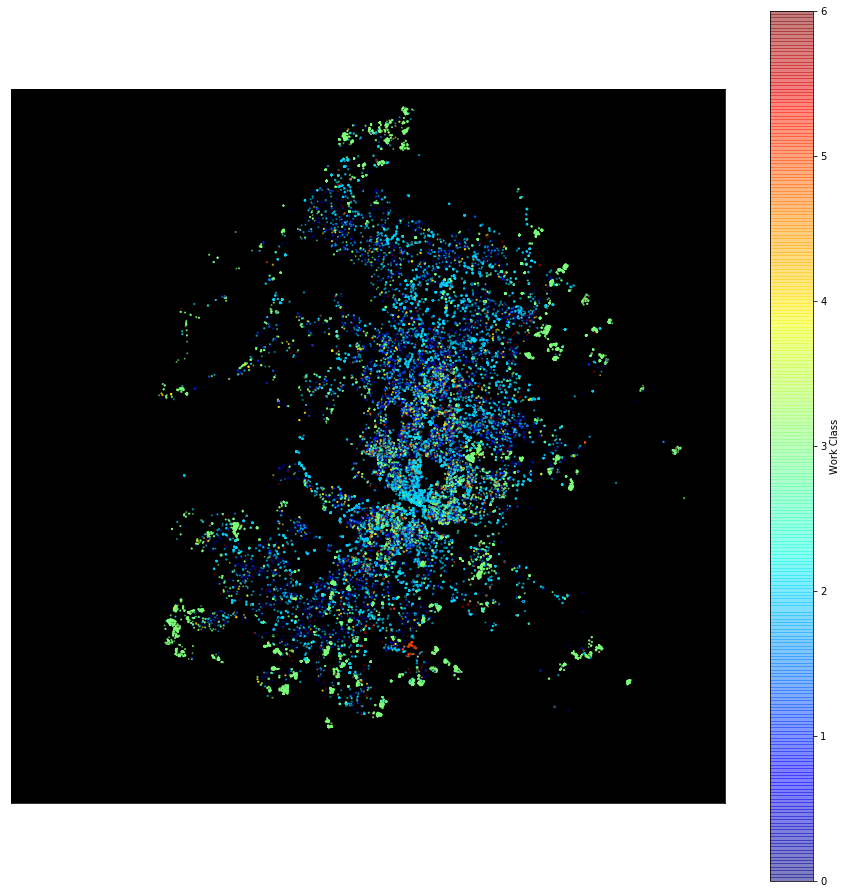

In [61]:
# Numerilize categorical variable permit_class_mapped
permit_class = train_df['permit_class_mapped'] #create variable of permit class mapped feature: Residential, Commercial
permit_class_encoded, permit_class_categories = permit_class.factorize() # factorize the categorical variable into numerical.
# Factorize made Residential = 0, Commercial = 1

# Numerilize categorical variable work_class
work_class = train_df['work_class'] 
work_class_encoded, work_class_categories = work_class.factorize() 

# Draw map background
fig, axes = plt.subplots()
fig.set_size_inches(16, 16)
axes.set_facecolor('black')
m = Basemap(projection='lcc', resolution='c', lat_0 = 30.30, lon_0 = -97.78, width = 5E4, height = 5E4)
m.scatter(lon, lat, latlon=True, c=work_class_encoded, s=permit_class_encoded+1, cmap=plt.get_cmap('jet'), alpha=0.5)

# Create colorbar and legend
plt.colorbar(label=r'Work Class')
plt.clim(0, 6)

print('0=Remodel, 1=Change Out, 2=Repair, 3=New, 4=Demolition, 5=Addition and Remodel, 6=Addition', '\n')
print('MAP OF PERMITS COLORED ACCORDING TO ITS WORK CLASS')

### Correlation

As we can see in the heatmap representation of the correlation matrix (which only inclcudes numerical variables, some of which we regard as categorical numerical) very few pairs of variables show a strong correlation. 

The most notable ones are:
1. duration and calendar_year_issued, corr=0.24. This is consistent with prior analysis, that permit approval duration is taking longer in more recent years.
2. duration and number_of_floors, corr=0.24. 



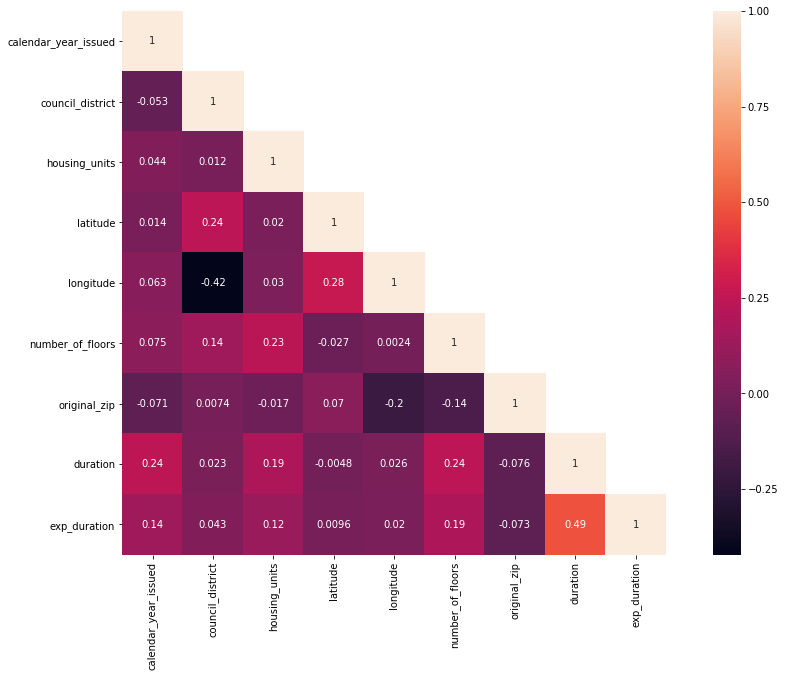

In [69]:
mask = np.array(train_df.corr())
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(17,10)
sns.heatmap(train_df.corr(), mask=mask, square=True,annot=True)

**The extent of data exploration done so far should be sufficient to help us better select models and analyze their results. Let's move on to creating our functions for preprocessing data so we may feed it in an adequate form into our models.**

## 3. Data Preprocessing

The following two cells of code define and run the functions we need to preprocess our data. It includes the following steps:
1. **Drop uninportant features -** These include all variables that based on common sense would not be good predictors, as well as those which have a large proprtion of their values missing.
2. **Drop rows with missin values -** As we saw in our training set, dropping rows with missing values after doing Step 1 removed almost 30% of our data. For the purposes of this projet is not too important to lose so many observations, but in a real-life problem it's probably a good idea to look at missing data in more detail and see how many values can be replaced. There are various methods for this, such as inserting the mean, mode or median values for each feature.
3. **Get dependent variable -** Use the applieddate, issue_date and expiresdate to get the duration (in days) for permits to be approved, and for them to expire as well. Remove the three original features just mentioned.
4. **Transform duration into log(duration)**
5. **Remove outliers -** those observation where duration is larger than 3 standard deviation away from the mean. We fit models both with and without outliers to see which provide a better result on the validation and test sets.
6. **Normalize and scale continuous variables -** Some ML models need this (NN), others don't (Linear Regression).
7. *Turn categorical variables into one-hot-encoded vectors.**
8. **Split data into X_train, X_test, y_train and y_test.**

In [6]:
# DATA PREPROCESSING FUNCTIONS

def drop_features(df, feats_to_drop):
    '''Drop features that were deemed irrelevant from the EDA, and columns with too many missing values'''
    df.drop(feats_to_drop, inplace=True, axis=1)
    return(df)

def drop_rows(df):
    '''Drops rows with missing values. This should be performed only after deleting those columns with mostly 
    missing values'''
    df.dropna(inplace=True, axis=0)
    return(df)

def get_durations_from_dates(df):
    '''Get days between applieddate and issue_date, as well as between applied_date and expired_date. Then
    drop the dates and keep only the days between them as features'''
    # Convert applieddate and issue_date columns into dates
    df['applieddate'] = df['applieddate'].apply(lambda x: datetime.strptime(x[:10], "%Y-%m-%d"))
    df['issue_date'] = df['issue_date'].apply(lambda x: datetime.strptime(x[:10], "%Y-%m-%d"))

    # Create approval_duration column 
    df['duration'] = df['issue_date'] - df['applieddate']
    df['duration'] = df['duration'].apply(lambda x: x.days)
    df = df[df['duration'] >= 0]
    df = df[df['duration'] <  4000]

    # Create exp_duration variable, similarly to above
    df['expiresdate'] = df['expiresdate'].apply(lambda x: datetime.strptime(x[:10], "%Y-%m-%d"))
    df['exp_duration'] = df['expiresdate'] - df['applieddate']
    df['exp_duration'] = df['exp_duration'].apply(lambda x: x.days)

    # Drop permit applied, issue and expiration dates
    df.drop(['applieddate', 'issue_date', 'expiresdate'], inplace=True, axis=1)
    return(df)
    
def log_transform(df):
    '''Transform duration into log(duration)'''
    df['duration'] = np.log(df['duration']+0.1) 
    return(df)

def remove_outliers(df):
    '''Remove Outliers'''
    count_mean = np.mean(df['duration'])
    count_std = np.std(df['duration'])
    three_std = count_mean + 3*count_std
    df = df[df['duration'] < three_std]
    return(df)

def norm_scale(df, cont_features):
    '''Normalize and Scale Continuous Features'''
    df[cont_features] -= np.mean(df[cont_features])
    df[cont_features] /= np.std(df[cont_features])
    return(df)

def split_into_x_y(df):
    df_train = df.drop('duration', axis=1).copy()
    df_test = df['duration'].copy()
    return([df_train, df_test])

def cat_into_one_hot(df, cat_features):
    '''Takes list of categorical features and turns them into One-Hot Encoding'''
    df = pd.get_dummies(df, columns=cat_features, drop_first=True)
    return(df)

def exp_transform(df):
    '''To convert duration back to non-log values'''
    if type(df) == pd.core.series.Series:
        df = np.exp(df)
    elif type(df) == np.ndarray:
        df = np.exp(df)
    else:
        df['duration'] = np.exp(df['duration'])
    return(df)

In [195]:
# Get Dataset
permits_df = permits_df_all.copy()

# Define Independent Features that will be either dropped, normalized or transformed throghout our data preprocessing
feats_to_drop = ['applicant_address1', 'applicant_address2', 'applicant_city', 'applicant_full_name', 'applicant_org',
                 'applicant_phone', 'applicantzip', 'building_valuation', 'building_valuation_remodel', 
                 'electrical_valuation', 'electrical_valuation_remodel', 'mechanical_valuation',
                 'mechanical_valuation_remodel', 'plumbing_valuation', 'plumbing_valuation_remodel',
                 'remodel_repair_sqft', 'total_job_valuation', 'total_new_add_sqft', 'total_valuation_remodel', 
                 'contractor_company_name', 'masterpermitnum', 'total_existing_bldg_sqft', 'medgas_valuation_remodel',
                    'contractor_address1', 'completed_date', 'contractor_full_name','original_address1', 'permit_number',
                 'contractor_address2', 'contractor_phone', 'contractor_zip','legal_description', 'original_state', 
                 'project_id', 'statusdate', 'tcad_id', 'status_current', 'permit_type_desc',
                'permit_location', 'original_city', 'issued_in_last_30_days', 'description', 'fiscal_year_issued',
                'location', 'link', 'contractor_city', 'council_district', 'jurisdiction', 'day_issued', 'issue_method',
                'original_zip', 'housing_units']
cat_features = ['condominium',  'permit_class_mapped','permit_class','work_class', 'permittype','contractor_trade']
cont_features = ['calendar_year_issued', 'latitude', 'longitude', 'number_of_floors', 'exp_duration']

# Drop Uninportant Features
permits_df = drop_features(permits_df, feats_to_drop)

# Drop Rows With Missing Values
permits_df = drop_rows(permits_df)

# Process Datetime
permits_df = get_durations_from_dates(permits_df)

# Remove Outliers - Only for Training Data
permits_df = remove_outliers(permits_df)

# Normalize and Standardize Continuous Variables
permits_df = norm_scale(permits_df, cont_features)

# Transform Data to Log - Only for Training Data
permits_df = log_transform(permits_df)

# Change Categorical into One_Hot
permits_df = cat_into_one_hot(permits_df, cat_features)

# Split into x and y datasets
x_df, y_df = split_into_x_y(permits_df)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, random_state=42)

# Check datasets shapes
print('We check the datasets shapes to ensure our pre-processing function did its job correctly: ', '\n')
print('X_train Shape: ', X_train.shape)
print('X_test Shape: ', X_test.shape)
print('y_train Shape: ', y_train.shape)
print('y_test Shape: ', y_test.shape)

We check the datasets shapes to ensure our pre-processing function did its job correctly:  

X_train Shape:  (56730, 74)
X_test Shape:  (18910, 74)
y_train Shape:  (56730,)
y_test Shape:  (18910,)


## 4. Predictive Models

### Model A: Linear Regression Model

In [196]:
# TRAIN MODEL: LINEAR REGRESSION

# Create a validation set to test results before testing on actual test set
X_train_lr, X_val_lr, y_train_lr, y_val_lr = train_test_split(X_train, y_train, random_state=1)

X_train_lr_intercept = sm.add_constant(X_train_lr, has_constant='add') # this adds an intercept term column
est = sm.OLS(y_train_lr, X_train_lr_intercept)
est2 = est.fit()
X_val_lr_intercept = sm.add_constant(X_val_lr, has_constant='add')
pred_lr = est2.predict(X_val_lr_intercept)
print(est2.summary())

# Convert back from Log_Count to Count
pred_lr = exp_transform(pred_lr)
y_val_lr = exp_transform(y_val_lr)

# Evaluate Model
# pred_lr[pred_lr<0] = 0
mse = np.sqrt(mean_squared_error(y_val_lr, pred_lr))
print('RMSE: ', mse)

                            OLS Regression Results                            
Dep. Variable:               duration   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     1406.
Date:                Tue, 04 Dec 2018   Prob (F-statistic):               0.00
Time:                        20:05:52   Log-Likelihood:                -79883.
No. Observations:               42547   AIC:                         1.599e+05
Df Residuals:                   42476   BIC:                         1.605e+05
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
                                                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

#### Analysis:
Linear Regression did not provide a great model. After trying many different iterations of features, the best model had an Adjusted R^2 score of 0.707 and a Root Mean Squared Error (RMSE) of 121 (when dropping outliers) and 705 (leaving outliers in). 

The model explains a good portion of the variance and is better than random guessing, but it won't provide accurate results. One benefit from trying the approach above using statsmodel though is that it gives us an idea of which features are better predictors. The p-values would not necessarily be indicative of which features hold their predictive value when using other models (Neural Networks or Random Forests, for instance) but it's a good starting point. 

Next we try various Ensemble Gradient Boosting models with combinations of sets of parameters to hopefully find a model with a lower RMSE.

### Model B: Ensemble Gradient Boosting

In [199]:
egb_params = [{'learning_rate': [0.1], 'max_depth':[16]}] # from previous run

egb = GradientBoostingRegressor(n_estimators=50, loss='ls')

grid_egb = GridSearchCV(egb, param_grid=egb_params, cv=5, refit=True, verbose=1)
grid_egb.fit(X_train, y_train)
best_score = grid_egb.best_score_
best_params = grid_egb.best_params_
print(' The Best Score :', best_score, '\n', 'The Best Params : ', best_params)
pred_egb = grid_egb.predict(X_test)

# Convert back from Log_Count to Count
pred_egb = exp_transform(pred_egb)
y_test_egb = exp_transform(y_test)

# Evaluate Model on Validation Set
# pred.resize(y_val_xg.shape)
rmse_egb = np.sqrt(mean_squared_error(y_test_egb, pred_egb))
print('RMSE Score: ', rmse_egb)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 17.6min finished


 The Best Score : 0.8283435635963338 
 The Best Params :  {'learning_rate': 0.1, 'max_depth': 16}
RMSE Score:  41.411195254409016


# CONTINUE HERE - REMEMBER TO PLOT BOTH PRED_EGB_NO0 AND PRED_EGB TO

#### Plot Residuals vs Predictions

ENSEMBLE GRADIENT BOOSTING WITH LOG TRANSFORMATION MODEL RESULTS
RMSE:  41.411195254409016


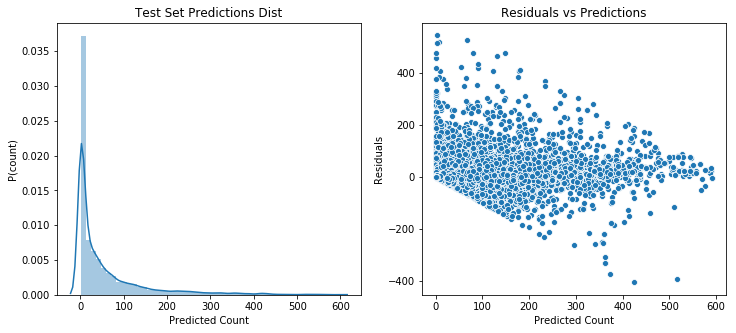

In [200]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 5)
sns.distplot(pred_egb, ax=axes[0])
axes[0].set(xlabel='Predicted Count', ylabel='P(count)', title='Test Set Predictions Dist' )

residuals = (y_test_egb - pred_egb)
sns.scatterplot(x=pred_egb, y=residuals, ax=axes[1])
axes[1].set(xlabel='Predicted Count', ylabel='Residuals', title='Residuals vs Predictions')

print('ENSEMBLE GRADIENT BOOSTING WITH LOG TRANSFORMATION MODEL RESULTS')
print('RMSE: ', rmse_egb)

#### Analysis:
The predicted values show a very similar distribution to that of the actual duration.

Also notice that the Residuals vs Predictions plot shows two clear pattern as diagonal lines that are bounding the distribution. This means there is some structure in the data which the model is not capturing. For the purposes of this analysis we won't try and resolve this but there is a series of things to try and do so. One is to try a different set of predicting variables. Another is to try a different transformation to the data (one other than log). 

**Assuming that you are applying for a permit and are actually interested in knowing how long it will take to get approved, it would be useful to know how much confidence to have in the model. Below is a plot that provides some visual representation of the errors made by the model.**

Text(0.5,1,'Proportion of Predictions For Each Error Distance Category')

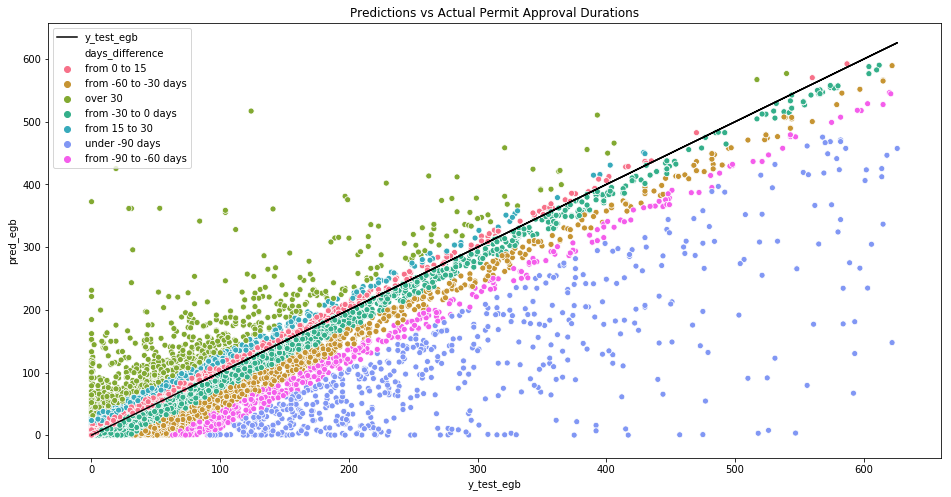

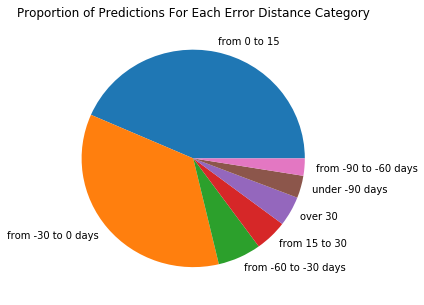

In [201]:
# Create Dataframe with Predictions and Actual values
comparison_df = pd.DataFrame(columns=['pred_egb', 'y_test_egb'])
comparison_df['pred_egb'] = pred_egb
comparison_df['y_test_egb'] = np.array(y_test_egb)
comparison_df['diff'] = comparison_df['pred_egb'] - comparison_df['y_test_egb']
comparison_df['days_difference'] = None

# Define categories of differences
comparison_df.loc[comparison_df['diff'] < -90, 'days_difference'] = 'under -90 days'
comparison_df.loc[(comparison_df['diff'] < -60) & (comparison_df['diff'] > -90), 'days_difference'] = 'from -90 to -60 days'
comparison_df.loc[(comparison_df['diff'] < -30) & (comparison_df['diff'] > -60), 'days_difference'] = 'from -60 to -30 days'
comparison_df.loc[(comparison_df['diff'] < 0) & (comparison_df['diff'] > -30), 'days_difference'] = 'from -30 to 0 days'
comparison_df.loc[(comparison_df['diff'] >= 0) & (comparison_df['diff'] < 15 ), 'days_difference'] = 'from 0 to 15'
comparison_df.loc[(comparison_df['diff'] >= 15) & (comparison_df['diff'] < 30 ), 'days_difference'] = 'from 15 to 30'
comparison_df.loc[comparison_df['diff'] > 30, 'days_difference'] = 'over 30'

# # Plot Predictions vs Actual
# fig, axes = plt.subplots(nrows=1, ncols=2)
# fig.set_size_inches(14, 6)

# sns.pointplot(x='y_test_egb', y='y_test_egb', data=comparison_df, scale=0.75, palette='magma', ax=axes[0])
# sns.scatterplot(x='y_test_egb', y='pred_egb', data=comparison_df, hue='over_under', palette='viridis', ax=axes[0])
# axes[0].set(title='Predictions vs Actual Permit Approval Durations')

# # Plot Distribution of Predictions
# axes[1].pie(comparison_df['over_under'].value_counts(), labels=comparison_df['over_under'].value_counts().index)
# axes[1].set(title='Proportion of Predictions For Each Error Distance Category')

# Plot Prediction vs Actual Durations
fig1 = plt.figure(figsize=(16, 8))
plt.plot(comparison_df['y_test_egb'], comparison_df['y_test_egb'], c='black')
sns.scatterplot(x='y_test_egb', y='pred_egb', data=comparison_df, hue='days_difference', palette='husl')
plt.title('Predictions vs Actual Permit Approval Durations')

# Plot Distribution of Predictions
fig2 = plt.figure(figsize=(5, 5))
plt.pie(comparison_df['days_difference'].value_counts(), labels=comparison_df['days_difference'].value_counts().index)
plt.title('Proportion of Predictions For Each Error Distance Category')

#### Analysis:
The scatter plot (top image) shows the distribution of predictions on the **test set** vs actual durations. The black diagonal is a plot of actual permit approval duration vs itself. The scatter points are predictions on those actual values. The colors represent bins in which the predictions fall as a measure of distance from the actual durations. For instance, in blue we can observe those predictions that under-estimated the approval duration by 90 days. Points below the black diagonal were under-estimation (meaning the actual duration was larger than predicted) and points above the black diagonal were over-estimated (the model predicted permit approval duration to be longer than it actually was).

From looking at that plot we get the impression that the model had the general idea, but was not very accurate. However, although there are many points far away from the diagonal line, the great majority of predictions were considerably close. To show that, we observe the pie chart showing how the great majority of predictions are within -30 and 15 days from the actual duration (I chose the value on the negative side to be larger since the errors are skewed towards the positive diretion). Moreover, we observe that even though when the model under-estimated it under-estimated by a larger margin, overall the model does over- or under-estimate systematically (meaning, the number of predictions above the diagonal line is virtually the same as the number below the line).

**From these results we can conclude that the model is useful in predicting how long it will take for a building permit to get approved. This can be useful to government and private entities in scheduling their services.**

### Final Thoughts
A couple of things that are not included in this notebook but would be beneficial to try:
1. Use the entire dataset instead of the first 100,000 observations.
2. From applieddate, extract the month on which the permit was requested. Construction tens to exhibit cyclical patterns, be it because of the weather, holidays, school schedule, or other large events happening in the city.
3. Try out more regression models, such as Artificual Neural Networks.


## I hope this was useful and interesting to you. Kindly share if you thought so.